In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

sns.set_style("darkgrid")

In [ ]:
# NREL Dataset https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=nrel-pds-building-stock%2Fend-use-load-profiles-for-us-building-stock%2F2021%2Fcomstock_amy2018_release_1%2Ftimeseries_individual_buildings%2Fby_state%2Fupgrade%3D0%2Fstate%3DUT%2F

In [ ]:
data = pd.read_csv("./Dataset/household_power_consumption.txt", sep=";")

In [ ]:
# convert to datetime
data["datetime"] = data["Date"] + " " + data["Time"]
data["datetime"] = pd.to_datetime(data["datetime"], dayfirst=True)

In [ ]:
#set datetime as index

data.drop(columns=["Date", "Time"], inplace=True)
data.set_index("datetime", inplace=True)


In [ ]:
# replace ? and convert each col to float and fillnas

for col in data.columns:
    data[col].replace("?", np.nan, inplace=True)
    data[col] = data[col].astype(np.float32)

data.ffill( axis=0, inplace=True)

In [ ]:
# concatenate by hour using index

data_resampled = data.resample("H").sum()
data_resampled["hour"] = data_resampled.index.hour
data_resampled.index = data_resampled.index.date


In [ ]:
# plot energy usage

data_resampled.pivot(columns='hour', values="Global_active_power").dropna().T.plot(figsize=(12, 6), alpha=0.02, color="blue", legend=False)

In [ ]:
# only get power and hour data 
data_pivot = data_resampled.pivot(columns="hour", values="Global_active_power").dropna()
train_x = data_pivot.values


In [ ]:
# elbow curve to get estimated profiles 

km_models = [KMeans(n_clusters=k, n_init="auto", random_state=42).fit(train_x) for k in range(2, 10)]
k_inertias = [model.inertia_ for model in km_models]

plt.figure(figsize=(6, 4))
sns.lineplot(x=range(2,10,1), y=k_inertias)
plt.title("Elbow curve")
plt.xlabel("k")
plt.ylabel("intertia")
plt.xticks(range(2, 10, 1));

In [ ]:
# silhoutte diagram to get estimated profiles

k_silhouttes = [silhouette_score(train_x, model.labels_) for model in km_models]

plt.figure(figsize=(6,4))
sns.lineplot(x=range(2,10,1), y=k_silhouttes)
plt.title("Silhoutte scores")
plt.xlabel("k")
plt.ylabel("Score")
plt.xticks(range(2,10,1));


In [ ]:
# use k=2
kmeans = KMeans(n_clusters=2, n_init="auto")
clusters = kmeans.fit_predict(train_x)
clusters_sr = pd.Series(clusters, name="cluster")


In [ ]:
cluster_df = data_pivot.set_index(clusters_sr, append=True)

In [ ]:
color = ["red", "black"]
cluster_labels = cluster_df.index.get_level_values(1).unique()

fig, ax = plt.subplots(figsize=(12, 6))
for cluster, color in zip(cluster_labels, color):

    cluster_df.xs(cluster, level=1).T.plot(alpha=0.02, color=color, legend=False, ax=ax)
    cluster_df.xs(cluster, level=1).T.median(axis=1).plot(color=color, ls="--", legend=False, ax=ax)

plt.ylabel("Power, kW")
plt.title("Power usage profiles")
plt.xticks(range(0, 24, 1));
    




In [ ]:
### COMMERCIAL BUILDING ANALYSIS
# NREL Dataset https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=nrel-pds-building-stock%2Fend-use-load-profiles-for-us-building-stock%2F2021%2Fcomstock_amy2018_release_1%2Ftimeseries_individual_buildings%2Fby_state%2Fupgrade%3D0%2Fstate%3DUT%2F

In [2]:
filepath = Path("./Dataset/")
filelist = list(filepath.glob("*.parquet"))
print(f"Buildings in dataset: {len(filelist)}")

Buildings in dataset: 21


In [3]:
electric_cols = ['timestamp','out.electricity.cooling.energy_consumption',
 'out.electricity.exterior_lighting.energy_consumption',
 'out.electricity.fans.energy_consumption',
 'out.electricity.heat_recovery.energy_consumption',
 'out.electricity.heat_rejection.energy_consumption',
 'out.electricity.heating.energy_consumption',
 'out.electricity.interior_equipment.energy_consumption',
 'out.electricity.interior_lighting.energy_consumption',
 'out.electricity.pumps.energy_consumption',
 'out.electricity.refrigeration.energy_consumption',
 'out.electricity.water_systems.energy_consumption',
 'out.electricity.total.energy_consumption',
 'out.electricity.cooling.energy_consumption_intensity',
 'out.electricity.exterior_lighting.energy_consumption_intensity',
 'out.electricity.fans.energy_consumption_intensity',
 'out.electricity.heat_recovery.energy_consumption_intensity',
 'out.electricity.heat_rejection.energy_consumption_intensity',
 'out.electricity.heating.energy_consumption_intensity',
 'out.electricity.interior_equipment.energy_consumption_intensity',
 'out.electricity.interior_lighting.energy_consumption_intensity',
 'out.electricity.pumps.energy_consumption_intensity',
 'out.electricity.refrigeration.energy_consumption_intensity',
 'out.electricity.water_systems.energy_consumption_intensity']

In [4]:
# Get each file and concat with only electric columns

data_df = pd.DataFrame()
for file in filelist:
    df = pd.read_parquet(file)
    electric_df = df[electric_cols]
    data_df = pd.concat([data_df, electric_df])
    data_df.fillna(0, inplace=True)

data_df.shape


(735840, 24)

In [5]:
# aggregate and preprocess data 

data_df = data_df.groupby("timestamp").mean()
data_resampled = data_df.resample('H').sum()
data_resampled["total_usage"] = data_resampled.sum(axis=1)

In [6]:
data_resampled["hour"] = data_resampled.index.hour
data_resampled["date"] = data_resampled.index.date
data_resampled.set_index("date", inplace=True)

<Axes: xlabel='hour'>

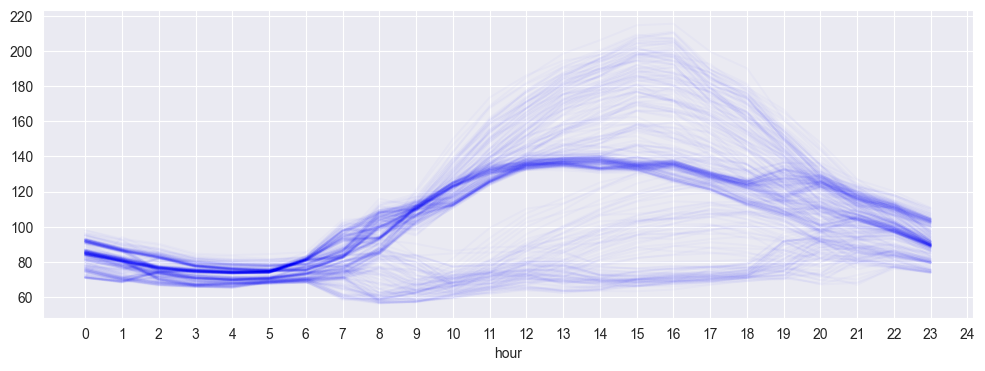

In [7]:
# only keep power data for now

data_power_only = data_resampled[["total_usage", "hour"]]
data_power_only = data_power_only.pivot(columns="hour", values="total_usage").dropna()
data_power_only.T.plot(figsize=(12, 4), xticks=range(0,25,1), legend=False, color="blue", alpha=0.02)

In [8]:
# clustering the data 

train_x = data_power_only.values
kmeans_models = [KMeans(n_clusters=k, n_init="auto").fit(train_x) for k in range(2,8)]

c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\sea

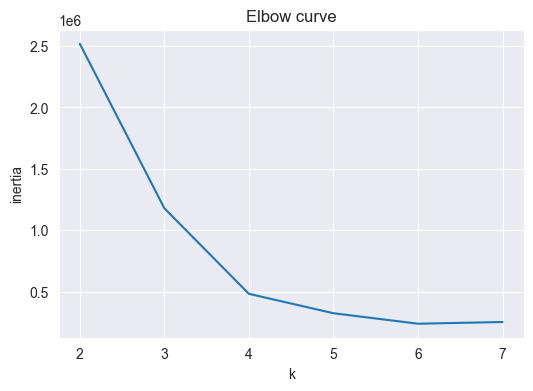

In [9]:
# get the elbow curve

inertias = [model.inertia_ for model in kmeans_models]

plt.figure(figsize=(6, 4))
sns.lineplot(x=range(2,8,1), y=inertias)
plt.xticks(range(2,8,1))
plt.xlabel("k")
plt.ylabel("inertia")
plt.title("Elbow curve");

c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\sea

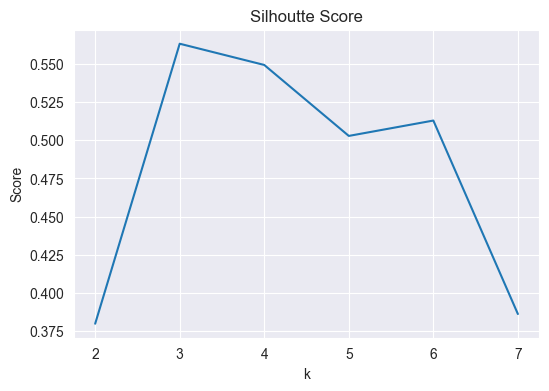

In [10]:
# get the silhoutte score
sil_score = [silhouette_score(train_x, model.labels_) for model in kmeans_models]

plt.figure(figsize=(6, 4))
sns.lineplot(x=range(2,8,1), y=sil_score)
plt.xticks(range(2,8,1))
plt.xlabel("k")
plt.ylabel("Score")
plt.title("Silhoutte Score");

In [11]:
# Use k=3

kmeans = KMeans(n_clusters=3, n_init="auto")
y_pred = kmeans.fit_predict(train_x)
y_series = pd.Series(y_pred, name="cluster")

In [12]:
clustered_df = data_power_only.set_index(y_series, append=True)

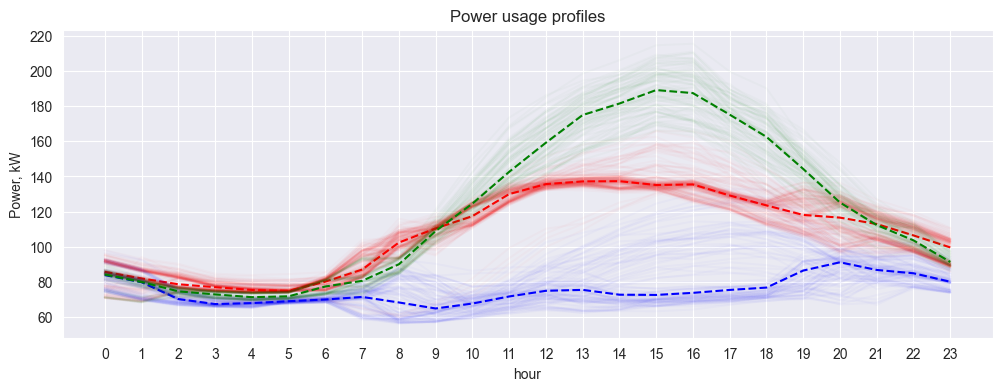

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
clusters = clustered_df.index.get_level_values(1).unique()
colors = ["red", "blue", "green"]
for cluster, color in zip(clusters, colors):
    clustered_df.xs(cluster, level=1).T.plot(color=color, ax=ax, alpha=0.02,legend=False)
    clustered_df.xs(cluster, level=1).T.median(axis=1).plot(color=color, ax=ax,legend=False, ls="--")
    
plt.ylabel("Power, kW")
plt.title("Power usage profiles")
plt.xticks(range(0, 24, 1));

In [55]:
# utilizing DBSCAN for clustering

minimum_samples = 30
knn = NearestNeighbors(n_neighbors=minimum_samples)
knn.fit(train_x)
distances, indices = knn.kneighbors(train_x)


c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\sea

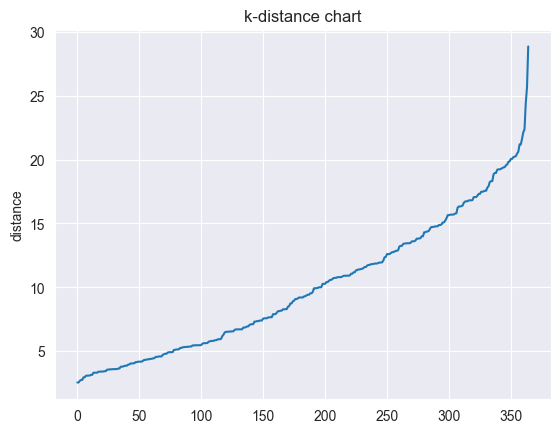

In [58]:
distances_sorted = np.sort(distances, axis=0)
distances_sorted = distances_sorted[:,1]
sns.lineplot(distances_sorted)
plt.ylabel("distance")
plt.title("k-distance chart");

In [64]:
eps = 24
dbscan = DBSCAN(eps=eps, min_samples = minimum_samples)
y_pred = dbscan.fit_predict(train_x)

In [65]:
y_sr = pd.Series(y_pred, name="cluster")
data_power_clustered = data_power_only.set_index(y_sr, append=True)

In [80]:
clusters = y_sr.unique()
colors = ["red", "blue", "green", "black", "magenta"]
cluster_colors = zip(clusters, colors[:len(clusters)])


In [81]:
for cluster, color in cluster_colors:
    number_days= data_power_clustered.xs(cluster, level=1).shape[0]
    print(f"Cluster {cluster} has {number_days} days, color used: {color}")

Cluster 0 has 91 days, color used: red
Cluster -1 has 169 days, color used: blue
Cluster 1 has 38 days, color used: green
Cluster 2 has 67 days, color used: black


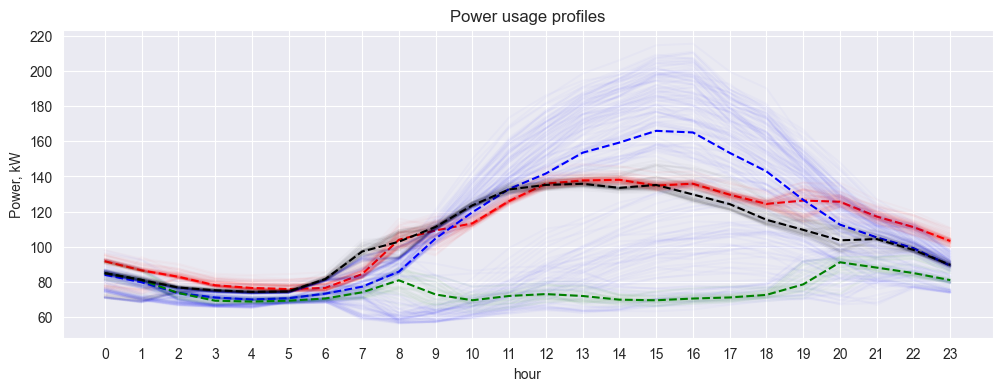

In [82]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
for cluster, color in zip(clusters, colors[:len(clusters)]):
    data_power_clustered.xs(cluster, level=1).T.plot(legend=False, alpha=0.02, ax=ax, color=color)
    data_power_clustered.xs(cluster, level=1).T.median(axis=1).plot(legend=False, color=color, ax=ax, ls="--")
plt.ylabel("Power, kW")
plt.title("Power usage profiles")
plt.xticks(range(0, 24, 1));